# Analysis of the properties of the MoTe₂/WSe₂ heterostructure from the perspective of electronic transport in the presence of an external magnetic field  (spin flip model).

The main aim of this script is to create computational model of the Chern insulator proposed in work: "Realization of the Haldane Chern insulator in a moiré lattice." - Zhao, Wenjin, et al, Nature Physics 20.2 (2024): 275-280. The authors report the experimental realization of a Haldane Chern insulator in AB-stacked $MoTe_2/WSe_2$ moiré bilayers, which form a honeycomb moiré lattice with two sublattices residing in diferent layers. Python program and results located below were created based on theory presented in this work.

This research was funded by the National Science Centre Poland (NCN) according to decision 2021/42/E/ST3/00128

In [32]:
from types import SimpleNamespace

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import kwant

import scipy.linalg as la
from math import atan2, pi, sqrt, exp

import scipy
import tinyarray
from IPython.display import display, Math

The primitive translation vectors of the honeycomb lattice are defined as follows: 

\begin{equation*}
    \mathbf{a} = [1,0],  \hspace{3mm} \mathbf{b} = [\frac{1}{2}, \frac{\sqrt{3}}{2}],
\end{equation*}
together with a vector connecting A and B sites equal to $\mathbf{c} = [0 , \frac{1}{\sqrt{3}}]$.

In [33]:
#The fundamental translation vectors
a = np.array([1, 0])
b = np.array([1/2, np.sqrt(3)/2])

#Vector from A to B site
c = np.array([0, 1/(np.sqrt(3))])

#Vectors AB
delta_AB_1 = c 
delta_AB_2 = c - b
delta_AB_3 = a - b + c 
deltas_AB = [delta_AB_1, delta_AB_2, delta_AB_3]

#Vectors BA
delta_BA_1 = (-1)*c 
delta_BA_2 = b-c
delta_BA_3 = (-1)*(a - b + c)
deltas_BA = [delta_BA_1, delta_BA_2, delta_BA_3]

#Vectors AA 
delta_AA_1 = (-1)*a
delta_AA_2 = b 
delta_AA_3 = a-b 
delta_AA_4 = a 
delta_AA_5 = (-1)*b  
delta_AA_6 = np.array([-0.5, np.sqrt(3)/(2)]) 
deltas_AA = [delta_AA_1, delta_AA_2, delta_AA_3, delta_AA_4, delta_AA_5, delta_AA_6]

#Vectors BB
delta_BB_1 = (-1)*a
delta_BB_2 = b
delta_BB_3 = a-b 
delta_BB_4 = a 
delta_BB_5 = (-1)*b
delta_BB_6 = b-a 
deltas_BB = [delta_BB_1, delta_BB_2, delta_BB_3, delta_BB_4, delta_BB_5, delta_BB_6]


The following tight-binding Hamiltonian was adopted:
\begin{align*}
H_\alpha &= -\sum_{\langle i,j \rangle,\alpha,\sigma} \left( t_\alpha e^{i s_\sigma \mathbf{v}_{i,j} \phi_\alpha} a_{i\sigma}^\dagger a_{j\sigma} + \text{h.c.} \right) 
- \sum_{i \in \alpha} \frac{\tau_\alpha \Delta}{2} n_i + \sum_{i \in \alpha, \sigma} V_z s_\sigma n_{i\sigma}, \\
H_{AB} &= -t_{AB} \sum_{\langle i,j \rangle,\sigma} a_{i\sigma}^\dagger a_{j\bar{\sigma}},
\end{align*},

where: 

$\alpha = A,B$ denotes the two sublattices with $\tau_A = - \tau_B$ = 1, 

$\sigma = \uparrow, \downarrow$ denotes the z-component electron spin with $s_\uparrow = -s_\downarrow = 1$,

$v_{i,j} = \pm 1$ denotes the two opposite hopping directions (+1 for clokwise, -1 for anticlockwise),

$t_A, t_B, t_{AB}$ denotes hopping amplitude,

$V_z$ is the Zeeman energy,

$\Delta$ is the layer pottential difference,

$\phi$ is the phase.

It is important to note, that hopping from A to B site (or conversely) happens with a change of spin.

Above Hamiltonian was transformed into momentum space using Fourier transform and
presented in matrix form. In the method "problem_wlasny" we solve an eigen problem of the matrix: 


\begin{equation}
\begin{pmatrix}
f_{A_{\uparrow}A_{\uparrow}}(\mathbf{k}) + \frac{\Delta}{2} + V_z & 0 & 0 & f_{A_{\uparrow}B_{\downarrow}}(\mathbf{k}) \\
0 & f_{B_{\uparrow}B_{\uparrow}}(\mathbf{k}) - \frac{\Delta}{2} + V_z & f_{B_{\uparrow}A_{\downarrow}}(\mathbf{k}) & 0 \\
0 & f_{A_{\downarrow}B_{\uparrow}}(\mathbf{k}) & f_{A_{\downarrow}A_{\downarrow}}(\mathbf{k}) + \frac{\Delta}{2} - V_z & 0 \\
f_{B_{\downarrow}A_{\uparrow}}(\mathbf{k}) & 0 & 0 & f_{B_{\downarrow}B_{\downarrow}}(\mathbf{k}) - \frac{\Delta}{2} - V_z
\end{pmatrix}
\end{equation}

where: 

$f_{A_{\sigma}, A_{\sigma}}(\mathbf{k}) =  \sum_{\langle \langle i,j \rangle \rangle} t_{A} e^{i s_{\sigma} v_{i,j} \phi_A } e^{i \mathbf{k} \cdot \mathbf{\delta}_{i,j}}$, 

$f_{B_{\sigma}, B_{\sigma}}(\mathbf{k}) =  \sum_{\langle \langle i,j \rangle \rangle} t_{B} e^{i s_{\sigma} v_{i,j} \phi_B} e^{i \mathbf{k} \cdot \mathbf{\delta}_{i,j}}$, 

$f_{A_{\sigma} B_{\bar{\sigma}}}(\mathbf{k}) = \sum_{\langle i,j \rangle} t_{AB} e^{i \mathbf{k} \cdot \mathbf{\Delta}_{i,j}}$, 


$f_{B_{\sigma} A_{\bar{\sigma}}}(\mathbf{k}) = \sum_{\langle i,j \rangle} t_{AB} e^{i \mathbf{k} \cdot \mathbf{\Delta}_{j,i}}$, 

$\mathbf{\Delta}_{i,j}$ and $\mathbf{\delta}_{i,j}$  are the vectors connecting nearest and next-nearest-neighbours.


$f_{\alpha, \alpha^{\prime}}(\mathbf{k})$ is calculated with function$f_k$ that is defined in two cells below.  $\Delta$ has been taken as $\Delta = 16$ (in the code it is divided into onsiteA and onsiteB), and hopping amplitude $t_{AB}$ as $1 meV$. $t_A = t_B = 2 meV$, $\phi_A = \phi_B = \frac{2\pi}{3}$ and $V_z = 0$.  

Every result and chart presented below was created based on this parameter definition.  It should be noted that this Python script allow for easy adjustment of these values. Especially the Zeeman energy $V_z$ can be and should be manipulated in order to see how magnetic field affects the bands structure of the system. For $V_z = 0$ the material is Quantum Spin Hall insulator, but for higher magnetic field (for example $V_z = 2 meV$) it becomes the Chern insulator.



In [34]:
#Here we will define all of the hopping tables
faza = 2*np.pi/3
faza_AB = 0

#V_ij tables
v_AB = np.array([1, 1, 1])
v_BA = np.array([1, 1, 1])
v_AA = np.array([1, 1, 1, -1, -1, -1])
v_BB = np.array([1, 1, 1, -1, -1, -1])

#tables of hoppings
Hopping_AB_up = np.exp(1j * v_AB * faza_AB) #"faza_AB" is equal to 0 in this model, so all A-B hopping are equal to 1
Hopping_BA_up = np.exp(1j * v_BA * faza_AB)
Hopping_AB_down = np.exp(1j *  v_AB * faza_AB)
Hopping_BA_down = np.exp(1j *  v_BA * faza_AB)
Hopping_AA_up = np.exp(1j * 1 * v_AA * faza)
Hopping_BB_up = np.exp(1j * 1 * v_BB * faza)
Hopping_AA_down = np.exp(1j * (-1) * v_AA * faza)
Hopping_BB_down = np.exp(1j * (-1) * v_BB * faza)

#table of tables of hoppings that will be passed to the class "Hamiltonian"
Hopping_tables = np.array([Hopping_AB_up, Hopping_BA_up, Hopping_AB_down, Hopping_BA_down, 
                           Hopping_AA_up, Hopping_BB_up, Hopping_AA_down, Hopping_BB_down])

/tmp/ipykernel_29256/2409150139.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Hopping_tables = np.array([Hopping_AB_up, Hopping_BA_up, Hopping_AB_down, Hopping_BA_down,


Here, we create function $f_k$ that calculates sum of exponents in the form of  $\sum_{j} e^{i \mathbf{k} \cdot \mathbf{a}_j}$ multiplied by the hopping term. $\mathbf{a}_j$ are the vectors connecting nearest and next-nearest-neighbours. 

In [35]:
#range of k
N=100
kx = np.linspace(-4*np.pi/(3), 4*np.pi/(3), N)
ky = np.linspace(-8*np.pi/(7), 8*np.pi/(7), N)

#function that calculates f_k
def f_k(deltas_table, hopping_table, kx, ky):
    sum_f = 0
    for i in range(len(deltas_table)):
        sum_f += hopping_table[i] * np.exp(1j * (kx * deltas_table[i][0] + ky * deltas_table[i][1]))
    return sum_f

In [36]:
#CLass that contains all the important parameters and defines hamiltonian
class Hamiltonian:
    def __init__(self, onsiteA, onsiteB, t_AB, t_BA, t_AA, t_BB, Hopping_tables, deltas_AB_table, deltas_BA_table, deltas_AA_table, deltas_BB_table, Bx, By, Bz):
        #Onsite energies
        self.onsiteA = onsiteA 
        self.onsiteB = onsiteB
        #Magnetic field
        self.Bx = Bx
        self.By = By
        self.Bz = Bz
        #hopping amplitude
        self.t_AB = t_AB
        self.t_BA = t_BA
        self.t_AA = t_AA
        self.t_BB = t_BB
        #Tables of lattice vectors
        self.deltas_AB_table = deltas_AB_table
        self.deltas_BA_table = deltas_BA_table
        self.deltas_AA_table = deltas_AA_table
        self.deltas_BB_table = deltas_BB_table

        #Tables of hoppings
        self.hopping_AB_up = Hopping_tables[0]
        self.hopping_BA_up = Hopping_tables[1]
        self.hopping_AB_down = Hopping_tables[2]
        self.hopping_BA_down = Hopping_tables[3]
        self.hopping_AA_up = Hopping_tables[4]
        self.hopping_BB_up = Hopping_tables[5]
        self.hopping_AA_down = Hopping_tables[6]
        self.hopping_BB_down = Hopping_tables[7]
#Method that solves eigen-problem
    def problem_wlasny(self, kx, ky):

            Matrix = np.zeros((4,4), dtype = complex)
            Matrix[0][3] = f_k(self.deltas_AB_table, self.hopping_AB_up * self.t_AB, kx, ky)
            Matrix[1][2] = f_k(self.deltas_BA_table, self.hopping_BA_up * self.t_BA, kx, ky) #AB and BA hoppings
            Matrix[2][1] = f_k(self.deltas_AB_table, self.hopping_AB_down * self.t_AB, kx, ky)
            Matrix[3][0] = f_k(self.deltas_BA_table, self.hopping_BA_down * self.t_BA, kx, ky)
            
            #Magnetic Field Bx and By
            Matrix[0][2] = self.Bx - 1j * self.By
            Matrix[1][3] = self.Bx - 1j * self.By
            Matrix[2][0] = self.Bx + 1j * self.By
            Matrix[3][1] = self.Bx + 1j * self.By
            
            
            Matrix[0][0] = self.onsiteA + 1 * self.Bz + f_k(self.deltas_AA_table, self.hopping_AA_up * self.t_AA, kx, ky).real #up AA and BB hoppings
            Matrix[1][1] = self.onsiteB + 1 * self.Bz + f_k(self.deltas_BB_table, self.hopping_BB_up * self.t_BB, kx, ky).real #up  
            Matrix[2][2] = self.onsiteA + (-1) * self.Bz + f_k(self.deltas_AA_table, self.hopping_AA_down * self.t_AA, kx, ky).real #down
            Matrix[3][3] = self.onsiteB + (-1) * self.Bz + f_k(self.deltas_BB_table, self.hopping_BB_down * self.t_BB, kx, ky).real #down
            ene, v = np.linalg.eigh(Matrix) 
            return ene, v 
              
    def minor_1(self, kx, ky):
            Matrix = np.zeros((2,2), dtype = complex)
            Matrix[0][0] = self.onsiteA + 1 * self.Bz + f_k(self.deltas_AA_table, self.hopping_AA_up * self.t_AA, kx, ky).real 
            Matrix[1][1] = self.onsiteB + (-1) * self.Bz + f_k(self.deltas_BB_table, self.hopping_BB_down * self.t_BB, kx, ky).real
            Matrix[0][1] = f_k(self.deltas_AB_table, self.hopping_AB_up * self.t_AB, kx, ky)
            Matrix[1][0] = f_k(self.deltas_BA_table, self.hopping_BA_down * self.t_BA, kx, ky)
            ene, v = np.linalg.eigh(Matrix) 
            return ene, v 
            
            
    def minor_2(self, kx, ky):
            Matrix = np.zeros((2,2), dtype = complex)
            Matrix[0][0] = self.onsiteA + (-1) * self.Bz + f_k(self.deltas_AA_table, self.hopping_AA_down * self.t_AA, kx, ky).real 
            Matrix[1][1] = self.onsiteB + 1 * self.Bz + f_k(self.deltas_BB_table, self.hopping_BB_up * self.t_BB, kx, ky).real 
            Matrix[0][1] = f_k(self.deltas_AB_table, self.hopping_AB_down * self.t_AB, kx, ky)
            Matrix[1][0] = f_k(self.deltas_BA_table, self.hopping_BA_up * self.t_BA, kx, ky) #AB and BA hoppings
            ene, v = np.linalg.eigh(Matrix) 
            return ene, v 

Here, we only draw function $f_k$ to see, if everything works fine.

Onsite energy = 0.2
t_aa = 2


Text(0.5, 1.0, 'BB')

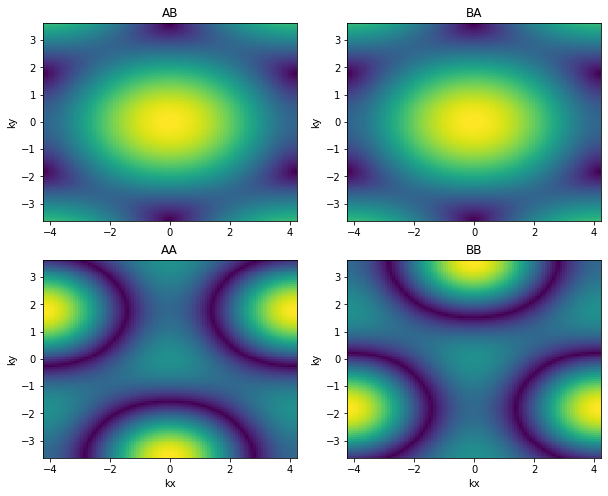

In [37]:
#Drawing f_k function
Onsite = 0.2
t_aa = 2
t_bb = 2
t_ab = 1
t_ba = 1
faza = 2*np.pi/3
Onsite_A = -8
Onsite_B = 8
faza = 2*np.pi/3
faza_AB = 0
Vz = 0
#tables of directions of hoppings
v_AB = np.array([1, 1 ,1])*t_ab
v_BA = np.array([1, 1, 1])*t_ba
v_AA = np.array([1, 1, 1, -1, -1, -1])
v_BB = np.array([1, 1, 1, -1, -1, -1])
#Exponent in the first sum of the hamiltonian (for different sites and spins)
faza_AA_up = np.exp(1j * 1 * v_AA * faza)*t_aa
faza_BB_up = np.exp(1j * 1 * v_BB * faza)*t_bb
faza_AA_down = np.exp(1j * (-1) * v_AA * faza)*t_aa
faza_BB_down = np.exp(1j * (-1) * v_BB * faza)*t_bb

Kx, Ky = np.meshgrid(kx,ky)
e_AB_values = np.zeros((N,N), dtype = complex)
e_BA_values = np.zeros((N,N), dtype = complex)
e_AA_values = np.zeros((N,N), dtype = complex)
e_BB_values = np.zeros((N,N), dtype = complex)
for i in range(N):
    for j in range(N):
        e_AB_values[i][j] = f_k(deltas_AB, v_AB, kx[i],ky[j]) 
        e_BA_values[i][j] = f_k(deltas_BA, v_BA, kx[i],ky[j]) 
        e_AA_values[i][j] = f_k(deltas_AA, faza_AA_up, kx[i],ky[j]) 
        e_BB_values[i][j] = f_k(deltas_BB, faza_AA_down, kx[i],ky[j]) 

print(f"Onsite energy = {Onsite}")
print(f"t_aa = {t_aa}")
    
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    
axs[0, 0].pcolor(Kx, Ky, abs(e_AB_values),  shading='auto' )
#axs[0, 0].set_xlabel("kx")
axs[0, 0].set_ylabel("ky")
axs[0, 0].set_title("AB")
    
axs[0, 1].pcolor(Kx, Ky, abs(e_BA_values),  shading='auto' )
#axs[0, 1].set_xlabel("kx")
axs[0, 1].set_ylabel("ky")
axs[0, 1].set_title("BA")
    
axs[1, 0].pcolor(Kx, Ky, abs(e_AA_values),  shading='auto' )
axs[1, 0].set_xlabel("kx")
axs[1, 0].set_ylabel("ky")
axs[1, 0].set_title("AA")
    
axs[1, 1].pcolor(Kx, Ky, abs(e_BB_values),  shading='auto' )
axs[1, 1].set_xlabel("kx")
axs[1, 1].set_ylabel("ky")
axs[1, 1].set_title("BB")

# plt.pcolor(Kx, Ky, abs(e_AB_values),  shading='auto' )
# plt.xlabel("kx")
# plt.ylabel("ky")
# plt.colorbar()
# plt.title(r"$|f_{A_{\sigma},B_{\bar{\sigma}}}(\mathbf{k})| = |f_{B_{\sigma},A_{\bar{\sigma}}}(\mathbf{k})|$")
# plt.savefig('f_k_2_1.jpg', dpi = 300, bbox_inches='tight')
# plt.show

# plt.pcolor(Kx, Ky, abs(e_AA_values),  shading='auto' )
# plt.xlabel("kx")
# plt.ylabel("ky")
# plt.title(r"$|f_{A_{\uparrow}, A_{\uparrow}}(\mathbf{k})| = |f_{B_{\uparrow}, B_{\uparrow}}(\mathbf{k})|$")
# plt.savefig('f_k_2_2.jpg', dpi = 300, bbox_inches='tight')
# plt.show

# plt.pcolor(Kx, Ky, abs(e_BB_values),  shading='auto' )
# plt.xlabel("kx")
# plt.ylabel("ky")
# plt.title(r"$|f_{A_{\downarrow}, A_{\downarrow}}(\mathbf{k})| = |f_{B_{\downarrow}, B_{\downarrow}}(\mathbf{k})|$")
# plt.savefig('f_k_2_3.jpg', dpi = 300, bbox_inches='tight')
# plt.show

Now, we will calculate the bandstructure. We take $\mathbf{k}$ on a certain path that contains characteristic points ($\Gamma$, $K^{'}$, $M$, $K$, $\Gamma$). Below, we define the path.

In [38]:
# Defining points in the first Brillouin zone
# Path: Gamma -> K' -> M -> K -> Gamma
K2 = np.array([2*np.pi/(3), 2*np.pi*np.sqrt(3)/(3)])
Gamma = np.array([0, 0])
M = np.array([2*np.pi/(2), 2*np.pi*np.sqrt(3)/(6)])
K = np.array([2*np.pi*2/(3), 0])
path_points = [Gamma, K2/2, K2,  M, K, K/2, Gamma]
path_labels = ["Γ", " ","K'", "M","K", " ", "Γ"]

# Defining k_values on the path 
num_points = 200
k_vals = []
for i in range(len(path_points) - 1):
    k_vals += list(np.linspace(path_points[i], path_points[i+1], num_points))

Now, we can calculate the bandstructure.

In [39]:
def plot_wf(Bz=0, Bx=0, By=0, delta=16, t_AB=1):

    #Parameters
    Delta = delta
    Onsite_A = -Delta/2
    Onsite_B = Delta/2
    faza = 2*np.pi/3
    faza_AB =  0
    t_ab = t_AB
    t_ba = t_AB
    t_aa = 2
    t_bb = 2

    #Matrices for energies
    ene_matrix_1 = []
    ene_matrix_2 = []
    ene_matrix_3 = []
    ene_matrix_4 = []

    #Matrices for spin colormap
    spin1_values = []
    spin2_values = []
    spin3_values = []
    spin4_values = []  

    #Matrices for A/B sites colormap
    A1_values = []
    A2_values = []
    A3_values = []
    A4_values = []

    for index, kvals in enumerate(k_vals):
        kx_vals, ky_vals = kvals
        hamiltonian = Hamiltonian(Onsite_A, Onsite_B, t_ab, t_ba, t_aa, t_bb, Hopping_tables, deltas_AB, deltas_BA, deltas_AA, deltas_BB, Bx, By, Bz) 
        ene, v = hamiltonian.problem_wlasny(kx_vals, ky_vals)
        ene_matrix_1.append(ene[0])
        ene_matrix_2.append(ene[1])
        ene_matrix_3.append(ene[2])
        ene_matrix_4.append(ene[3])  

        #Adding elements of eigen vectors that correspond to spin-up
        spin1_values.append(abs(v[0][0])**2 + abs(v[1][0])**2) 
        spin2_values.append(abs(v[0][1])**2 + abs(v[1][1])**2)
        spin3_values.append(abs(v[0][2])**2 + abs(v[1][2])**2)
        spin4_values.append(abs(v[0][3])**2 + abs(v[1][3])**2)

        #Adding elements of eigen vectors that correspond to B-site
        A1_values.append(abs(v[1][0])**2 + abs(v[3][0])**2)
        A2_values.append(abs(v[1][1])**2 + abs(v[3][1])**2)
        A3_values.append(abs(v[1][2])**2 + abs(v[3][2])**2)
        A4_values.append(abs(v[1][3])**2 + abs(v[3][3])**2)

    #Printing parameters
    print(f"Delta = {Onsite_A*2}")
    print(f"Zeeman energy Vz = {Vz}")
    print(f"t_aa = t_bb =  {t_aa}")
    print(f"t_ab = t_ba = {t_ab}")
    x_axis = np.linspace(1, num_points*6, num_points*6) # k-values

    #Drawing band structure with spin colormap
    plt.figure(figsize=(8, 6))
    plt.scatter(x_axis, ene_matrix_1, c=spin1_values, cmap='coolwarm', s=1)
    plt.scatter(x_axis, ene_matrix_2, c=spin2_values, cmap='coolwarm', s=1)
    plt.scatter(x_axis, ene_matrix_3, c=spin3_values, cmap='coolwarm', s=1)
    plt.scatter(x_axis, ene_matrix_4, c=spin4_values, cmap='coolwarm', s=1)
    plt.colorbar() 
    plt.title('Red for spin up, blue for spin down')
    plt.xticks([0, num_points, 2*num_points, 3*num_points, 4*num_points, 5*num_points, 6*num_points], path_labels)
   # plt.savefig('Spin_4.jpg', dpi = 300, bbox_inches='tight')
    plt.show()

    #Drawing band structure with A/B sites colormap
    plt.figure(figsize=(8, 6))
    plt.scatter(x_axis, ene_matrix_1, c=A1_values, cmap='inferno', vmin=0, vmax=1, s=1)
    plt.scatter(x_axis, ene_matrix_2, c=A2_values, cmap='inferno', vmin=0, vmax=1, s=1)
    plt.scatter(x_axis, ene_matrix_3, c=A3_values, cmap='inferno', vmin=0, vmax=1, s=1)
    plt.scatter(x_axis, ene_matrix_4, c=A4_values, cmap='inferno', vmin=0, vmax=1, s=1)
    plt.colorbar() 
    plt.title('Black for A-site, yellow for B-site')
    plt.xticks([0, num_points, 2*num_points, 3*num_points, 4*num_points, 5*num_points, 6*num_points], path_labels)
    #plt.savefig('Site_4.jpg', dpi = 300, bbox_inches='tight')
    plt.show()

interact(plot_wf, Bz=(-10.0, 10.0), Bx=(-10.0, 10.0), By=(-10.0, 10.0), delta=(-60.0, 60.0), t_AB=(-10, 10));

interactive(children=(FloatSlider(value=0.0, description='Bz', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

In [125]:
#Here, we calculate the bandstructure again, but the Hamiltonian is divided into two independent parts
def plot_wf(Bz=0, Bx=0, By=0, delta=16, t_AB=1):

    #Parameters
    Delta = delta
    Onsite_A = -Delta/2
    Onsite_B = Delta/2
    faza = 2*np.pi/3
    faza_AB = 0
    t_ab = t_AB
    t_ba = t_AB
    t_aa = 2
    t_bb = 2

    #Matrices for energies
    ene_matrix_1 = []
    ene_matrix_2 = []
    ene_matrix_3 = []
    ene_matrix_4 = []

    #Matrices for spin colormap
    spin1_values = []
    spin2_values = []
    spin3_values = []
    spin4_values = []  

    #Matrices for A/B sites colormap
    A1_values = []
    A2_values = []
    A3_values = []
    A4_values = []

    for index, kvals in enumerate(k_vals):
        kx_vals, ky_vals = kvals
        hamiltonian = Hamiltonian(Onsite_A, Onsite_B, t_ab, t_ba, t_aa, t_bb, Hopping_tables, deltas_AB, deltas_BA, deltas_AA, deltas_BB, Bx, By, Bz) 
        ene, v = hamiltonian.minor_1(kx_vals, ky_vals)
        ene2, v2 = hamiltonian.minor_2(kx_vals, ky_vals)
        ene_matrix_1.append(ene[0])
        ene_matrix_2.append(ene[1])
        ene_matrix_3.append(ene2[0])
        ene_matrix_4.append(ene2[1])

        #Adding elements of eigen vectors that correspond to spin-up
        spin1_values.append(abs(v[0][0])**2)
        spin2_values.append(abs(v[0][1])**2)
        spin3_values.append(abs(v2[0][0])**2)
        spin4_values.append(abs(v2[0][1])**2)

    #Printing parameters
    print(f"Delta = {Onsite_A*2}")
    print(f"Zeeman energy Vz = {Vz}")
    print(f"t_aa = t_bb =  {t_aa}")
    print(f"t_ab = t_ba = {t_ab}")
    x_axis = np.linspace(1, num_points*6, num_points*6) # k-values

    #Drawing band structure with spin colormap
    plt.figure(figsize=(8, 6))
    plt.scatter(x_axis, ene_matrix_1, c=spin1_values, cmap='coolwarm', s=1)
    plt.scatter(x_axis, ene_matrix_2, c=spin2_values, cmap='coolwarm', s=1)
    plt.colorbar() 
    plt.title('Red for spin up, blue for spin down')
    plt.xticks([0, num_points, 2*num_points, 3*num_points, 4*num_points, 5*num_points, 6*num_points], path_labels)
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x_axis, ene_matrix_3, c=spin3_values, cmap='coolwarm', s=1)
    plt.scatter(x_axis, ene_matrix_4, c=spin4_values, cmap='coolwarm', s=1)
    plt.colorbar() 
    plt.title('Red for spin up, blue for spin down')
    plt.xticks([0, num_points, 2*num_points, 3*num_points, 4*num_points, 5*num_points, 6*num_points], path_labels)
    plt.show()

interact(plot_wf, Bz=(-10.0, 10.0), Bx=(-10.0, 10.0), By=(-10.0, 10.0), delta=(-60.0, 60.0), t_AB=(-10, 10));

interactive(children=(FloatSlider(value=0.0, description='Bz', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

In [115]:
#Here we start to calculate Berry Phase and Chern number, first we define some important parameters

#momentum space vectors
b1 = np.array([2*np.pi, 2*np.pi*np.sqrt(3)/(3)])
b2 = np.array([0,2*np.pi*2*np.sqrt(3)/(3)])
b3 = b2 + b1


#Creating grid points for caluclating berry curvature and chern number
N2 = 100
k1 = np.linspace(0, 1, N2)
k2 = np.linspace(0, 1, N2)

kx_values = np.zeros((N2,N2))
ky_values = np.zeros((N2,N2))
            
grid_points = np.zeros((N2,N2), dtype = object)         

for index_i,i in enumerate(k1):
    for index_j,j in enumerate(k2):
        point  = i*b1 + j*b3
        grid_points[index_i][index_j] = point
        #kx and ky values for drawing berry curvature
        kx_values[index_i][index_j] = (grid_points[index_i][index_j][0])
        ky_values[index_i][index_j] = (grid_points[index_i][index_j][1])


/tmp/ipykernel_6952/355336144.py:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(kx_values, ky_values, berry_values_1)


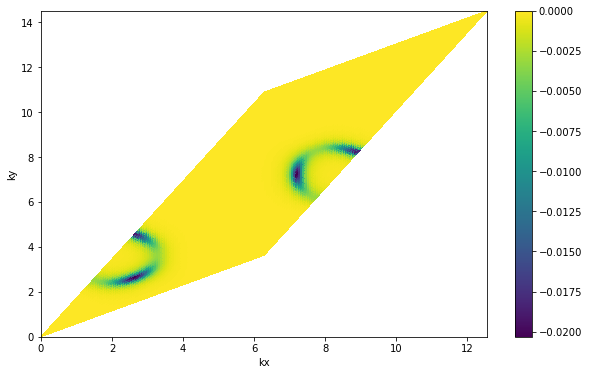

/tmp/ipykernel_6952/355336144.py:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(kx_values, ky_values, berry_values_2)


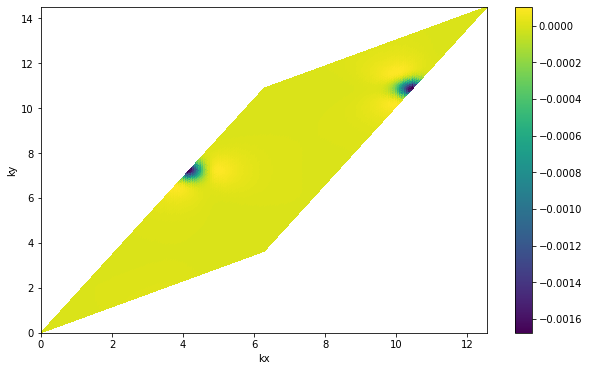

Chern number 1 = -1.0000000000000004
Chern number 2 = -1.3256177209820652e-16


In [116]:
#Hamiltonian is divided into two independent parts
#The Berry curvature and Chern number are calculated separately for each part
wynik = 0
iloczyn = 0

faza = 2*np.pi/3
faza_AB = 0
B_x = 0
B_y = 0
B_z = 2
t_aa = 2
t_bb = 2
t_ab = 1
t_ba = 1
Onsite_A = -8
Onsite_B = 8

#Berry curvature values table for drawing 
berry_values_1 = np.zeros((N2,N2))
berry_values_2 = np.zeros((N2,N2))

hamiltonian_1 = Hamiltonian(Onsite_A, Onsite_B, t_ab, t_ba, t_aa, t_bb, Hopping_tables, deltas_AB, deltas_BA, deltas_AA, deltas_BB, B_x, B_y, B_z) 
for i in range (N2-1):
    for j in range (N2-1):
        ene1, v1 = hamiltonian_1.minor_1(grid_points[i][j][0], grid_points[i][j][1])
        ene2, v2 = hamiltonian_1.minor_1(grid_points[i+1][j][0], grid_points[i+1][j][1])
        ene3, v3 = hamiltonian_1.minor_1(grid_points[i+1][j+1][0], grid_points[i+1][j+1][1])
        ene4, v4 = hamiltonian_1.minor_1(grid_points[i][j+1][0], grid_points[i][j+1][1])
            
        iloczyn = (v1[0][1].conjugate()*v2[0][1] + v1[1][1].conjugate()*v2[1][1]) * (v2[0][1].conjugate()*v3[0][1] + v2[1][1].conjugate()*v3[1][1])  * (v3[0][1].conjugate()*v4[0][1] + v3[1][1].conjugate()*v4[1][1]) * (v4[0][1].conjugate()*v1[0][1] + v4[1][1].conjugate()*v1[1][1]) #iloczyn skalarny
        wynik += np.angle(iloczyn) 
        berry_values_1[i][j]=np.angle(iloczyn)
        
#Chern number for minor 1
chern_1 = wynik/(2*np.pi)
        
wynik = 0

hamiltonian_2 = Hamiltonian(Onsite_A, Onsite_B, t_ab, t_ba, t_aa, t_bb, Hopping_tables, deltas_AB, deltas_BA, deltas_AA, deltas_BB, B_x, B_y, B_z) 
for i in range (N2-1):
    for j in range (N2-1):
        ene1, v1 = hamiltonian_2.minor_2(grid_points[i][j][0], grid_points[i][j][1])
        ene2, v2 = hamiltonian_2.minor_2(grid_points[i+1][j][0], grid_points[i+1][j][1])
        ene3, v3 = hamiltonian_2.minor_2(grid_points[i+1][j+1][0], grid_points[i+1][j+1][1])
        ene4, v4 = hamiltonian_2.minor_2(grid_points[i][j+1][0], grid_points[i][j+1][1])
            
        iloczyn = (v1[0][1].conjugate()*v2[0][1] + v1[1][1].conjugate()*v2[1][1]) * (v2[0][1].conjugate()*v3[0][1] + v2[1][1].conjugate()*v3[1][1])  * (v3[0][1].conjugate()*v4[0][1] + v3[1][1].conjugate()*v4[1][1]) * (v4[0][1].conjugate()*v1[0][1] + v4[1][1].conjugate()*v1[1][1]) #iloczyn skalarny
        wynik += np.angle(iloczyn) 
        berry_values_2[i][j]=np.angle(iloczyn)
        
#Chern number for minor 2
chern_2 = wynik/(2*np.pi)

#Drawing berry curvature
plt.figure(figsize=(10, 6))
plt.pcolor(kx_values, ky_values, berry_values_1) 
plt.colorbar() 
plt.xlabel("kx")
plt.ylabel("ky")
# plt.savefig('Berry_5.jpg', dpi = 300, bbox_inches='tight')
plt.show()   
plt.figure(figsize=(10, 6))
plt.pcolor(kx_values, ky_values, berry_values_2) 
plt.colorbar()  
plt.xlabel("kx")
plt.ylabel("ky")
# plt.savefig('Berry_6.jpg', dpi = 300, bbox_inches='tight')
plt.show()   
print(f"Chern number 1 = {chern_1}")
print(f"Chern number 2 = {chern_2}")

In the cells below, we will calculate the band structure again but this time with the help of the Kwant package. We create a system with certain height and width, we define primitive translation vectors and hoppings. Kwant creates the Hamiltonian and solves the eigen problem automatically. We take into account two different lattice boundaries: zigzag and armchair.

In [86]:
#Here we define functions that will be used to build MoTe2/WSe2 systems
def onsite_A(site, Bx, By, Bz, delta):
    return np.array([[-delta/2 + Bz, Bx - 1j*By], [Bx + 1j*By, -delta/2 - Bz]])

def onsite_B(site, Bx, By, Bz, delta):
    return np.array([[+delta/2 + Bz, Bx - 1j*By], [Bx + 1j*By, +delta/2 - Bz]])

def hopping_AA(site1, site2, faza, t_aa):
    t_AA_up = t_aa * np.exp(1j * 1 * faza)
    t_AA_down = t_aa * np.exp(1j * (-1) * faza)
    return np.array([[t_AA_up,0],[0,t_AA_down]])

def hopping_BB(site1, site2, faza, t_bb):
    t_BB_up = t_bb * np.exp(1j * 1 * faza)
    t_BB_down = t_bb * np.exp(1j * (-1) * faza)
    return np.array([[t_BB_up,0],[0,t_BB_down]])

v_ab = 1
v_ba = 1

def hopping_AB(site1, site2, faza_AB, t_ab):
    Hopping_AB = np.exp(1j * v_ab * faza_AB)
    return np.array([[0,t_ab*Hopping_AB],[t_ab*Hopping_AB,0]])

def hopping_BA(site1, site2, faza_AB, t_ab):
    Hopping_BA = np.exp(1j * v_ba * faza_AB)
    return np.array([[0,t_ab*Hopping_BA],[t_ab*Hopping_BA,0]])

In [87]:
#Function that creates zigzag MoTe2/WSe2 system
def build_graphene_system_zigzag(Lmin=-2, Lmax=2, Wmin=-10, Wmax=10):

    sys_gr1 = kwant.Builder()
    # Lattice
    graphene_lat = kwant.lattice.general([[1, 0], [1/2, np.sqrt(3)/2]],
                                         [[0, 0], [0, 1/np.sqrt(3)]], norbs=2)
    lat_A, lat_B = graphene_lat.sublattices

    def ribbon(pos):
        x, y = pos
        return Lmin <= x <= Lmax and Wmin <= y <= Wmax

    sys_gr1 = kwant.Builder()
    sys_gr1[lat_A.shape(ribbon, (0, 0))] = onsite_A
    sys_gr1[lat_B.shape(ribbon, (0, 0))] = onsite_B

    sys_gr1[graphene_lat.neighbors()] = hopping_AB

    sys_gr1[kwant.builder.HoppingKind((-1, 0), lat_A, lat_A)] = hopping_AA
    sys_gr1[kwant.builder.HoppingKind((0, 1), lat_A, lat_A)] = hopping_AA
    sys_gr1[kwant.builder.HoppingKind((1, -1), lat_A, lat_A)] = hopping_AA

    sys_gr1[kwant.builder.HoppingKind((-1, 0), lat_B, lat_B)] = hopping_BB
    sys_gr1[kwant.builder.HoppingKind((0, 1), lat_B, lat_B)] = hopping_BB
    sys_gr1[kwant.builder.HoppingKind((1, -1), lat_B, lat_B)] = hopping_BB

    def lead0_shape(pos):
        x, y = pos
        return Wmin <= y <= Wmax

    sym = kwant.TranslationalSymmetry([-1, 0])
    sym.add_site_family(graphene_lat.sublattices[0], other_vectors=[(-1, 2)])
    sym.add_site_family(graphene_lat.sublattices[1], other_vectors=[(-1, 2)])

    lead = kwant.Builder(sym)
    lead[lat_A.shape(lead0_shape, (0, 0))] = onsite_A
    lead[lat_B.shape(lead0_shape, (0, 0))] = onsite_B
    
    lead[graphene_lat.neighbors()] = hopping_AB

    lead[kwant.builder.HoppingKind((-1, 0), lat_A, lat_A)] = hopping_AA
    lead[kwant.builder.HoppingKind((0, 1), lat_A, lat_A)] = hopping_AA
    lead[kwant.builder.HoppingKind((1, -1), lat_A, lat_A)] = hopping_AA

    lead[kwant.builder.HoppingKind((-1, 0), lat_B, lat_B)] = hopping_BB
    lead[kwant.builder.HoppingKind((0, 1), lat_B, lat_B)] = hopping_BB
    lead[kwant.builder.HoppingKind((1, -1), lat_B, lat_B)] = hopping_BB

    sys_gr1.attach_lead(lead)
    sys_gr1.attach_lead(lead.reversed())

    return sys_gr1.finalized()


In [88]:
# In this cell, we plot the bandstructure of zigzag MoTe2/WSe2 system
def plot_wf(Bz=0, Bx=0, By=0, delta=16, t_ab=3):
#almost all parameters are defined here. They are passed to function "build_graphene_system" and then to onsite and hopping functions
    t_aa=2
    t_bb=2
    faza = 2*np.pi/3
    faza_AB = 0
    sysf_zigzag = build_graphene_system_zigzag()

    kwant.plotter.bands(sysf_zigzag.leads[1], show=True, fig_size = (8,6), params=dict(Bx=Bx, By=By, Bz=Bz, delta=delta, t_ab = t_ab,
                                                                                        faza = faza, faza_AB = faza_AB, t_aa = t_aa, t_bb = t_bb));
    kwant.plotter.bands(sysf_zigzag.leads[1], show=False, fig_size = (8,6), params=dict(Bx=Bx, By=By, Bz=Bz, delta=delta, t_ab = t_ab, 
                                                                                         faza = faza, faza_AB = faza_AB, t_aa = t_aa, t_bb = t_bb));
    plt.ylim(2,8)
    plt.grid()
    plt.show()
    
    
interact(plot_wf, Bz=(-10.0, 10.0), Bx=(-10.0, 10.0), By=(-10.0, 10.0), delta=(-60.0, 60.0), t_ab=(-10.0, 10.0));

interactive(children=(FloatSlider(value=0.0, description='Bz', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

In [89]:
#Function that creates armchair MoTe2/WSe2 system
def build_graphene_system_armchair(Lmin=-2, Lmax=2, Wmin=-10, Wmax=10):

    sys_gr1 = kwant.Builder()
    # Lattice
    graphene_lat = kwant.lattice.general([[np.sqrt(3)/2, -1/2], [np.sqrt(3)/2, 1/2]],  # lattice vectors
                                                    [[0,0], [1/(2*np.sqrt(3)), 1/2]], norbs=4)  # Coordinates of the sites
    lat_A, lat_B = graphene_lat.sublattices

    def ribbon(pos):
        x, y = pos
        return Lmin <= x <= Lmax and Wmin <= y <= Wmax

    sys_gr1 = kwant.Builder()
    sys_gr1[lat_A.shape(ribbon, (0, 0))] = onsite_A
    sys_gr1[lat_B.shape(ribbon, (0, 0))] = onsite_B

    sys_gr1[graphene_lat.neighbors()] = hopping_AB

    sys_gr1[kwant.builder.HoppingKind((-1, 0), lat_A, lat_A)] = hopping_AA
    sys_gr1[kwant.builder.HoppingKind((0, 1), lat_A, lat_A)] = hopping_AA
    sys_gr1[kwant.builder.HoppingKind((1, -1), lat_A, lat_A)] = hopping_AA

    sys_gr1[kwant.builder.HoppingKind((-1, 0), lat_B, lat_B)] = hopping_BB
    sys_gr1[kwant.builder.HoppingKind((0, 1), lat_B, lat_B)] = hopping_BB
    sys_gr1[kwant.builder.HoppingKind((1, -1), lat_B, lat_B)] = hopping_BB

    def lead0_shape(pos):
        x, y = pos
        return Wmin <= y <= Wmax

    sym = kwant.TranslationalSymmetry([np.sqrt(3), 0])
    sym.add_site_family(graphene_lat.sublattices[0], other_vectors=[(1, -1)])
    sym.add_site_family(graphene_lat.sublattices[1], other_vectors=[(1, -1)])

    lead = kwant.Builder(sym)
    lead[lat_A.shape(lead0_shape, (0, 0))] = onsite_A
    lead[lat_B.shape(lead0_shape, (0, 0))] = onsite_B
    
    lead[graphene_lat.neighbors()] = hopping_AB


    lead[kwant.builder.HoppingKind((-1, 0), lat_A, lat_A)] = hopping_AA
    lead[kwant.builder.HoppingKind((0, 1), lat_A, lat_A)] = hopping_AA
    lead[kwant.builder.HoppingKind((1, -1), lat_A, lat_A)] = hopping_AA

    lead[kwant.builder.HoppingKind((-1, 0), lat_B, lat_B)] = hopping_BB
    lead[kwant.builder.HoppingKind((0, 1), lat_B, lat_B)] = hopping_BB
    lead[kwant.builder.HoppingKind((1, -1), lat_B, lat_B)] = hopping_BB

    sys_gr1.attach_lead(lead)
    sys_gr1.attach_lead(lead.reversed())

    return sys_gr1.finalized()


In [90]:
# In this cell, we plot the bandstructure of armchair MoTe2/WSe2 system
def plot_wf(Bz=0, Bx=0, By=0, delta=16, t_ab=3):
#almost all parameters are defined here. They are passed to function "build_graphene_system" and then to onsite and hopping functions
    t_aa=2
    t_bb=2
    faza = 2*np.pi/3
    faza_AB = 0
    sysf_armchair = build_graphene_system_armchair()

    kwant.plotter.bands(sysf_armchair.leads[1], show=True, fig_size = (8,6), params=dict(Bx=Bx, By=By, Bz=Bz, delta=delta, t_ab = t_ab,
                                                                                        faza = faza, faza_AB = faza_AB, t_aa = t_aa, t_bb = t_bb));
    kwant.plotter.bands(sysf_armchair.leads[1], show=False, fig_size = (8,6), params=dict(Bx=Bx, By=By, Bz=Bz, delta=delta, t_ab = t_ab, 
                                                                                         faza = faza, faza_AB = faza_AB, t_aa = t_aa, t_bb = t_bb));
    plt.ylim(2,8)
    plt.grid()
    plt.show()
    
interact(plot_wf, Bz=(-10.0, 10.0), Bx=(-10.0, 10.0), By=(-10.0, 10.0), delta=(-60.0, 60.0), t_ab=(-10.0, 10.0));

interactive(children=(FloatSlider(value=0.0, description='Bz', max=10.0, min=-10.0), FloatSlider(value=0.0, de…

# Acknowledgements

This research was funded by the National Science Centre Poland (NCN) according to decision 2021/42/E/ST3/00128